In [1]:
from __future__ import print_function

import sys
import os
import pandas as pd
import numpy as np

from keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense
from keras.models import Model, load_model

# To import 'katakana' from relative path
sys.path.append(os.path.abspath(os.path.join('..')))
from katakana import encoding

INPUT_LENGTH = 20
OUTPUT_LENGTH = 20


Using TensorFlow backend.


# Data pre-processing

In [2]:
data = pd.read_csv('../data/joined_titles.csv', header=None)
data = data.sample(frac=1, random_state=0)

data_input = [s.decode('utf-8').lower() for s in data[0]]
data_output = [s.decode('utf-8') for s in data[1]]
print(data_input[0], data_output[0])
print(data_input[5], data_output[5])

data_size = len(data)

# We will use the first 0-60th %-tile (60%) of data for the training
training_input  = data_input[data_size*0/100:data_size*60/100]
training_output = data_output[data_size*0/100:data_size*60/100]

# We will use the first 60-70th %-tile (10%) of data for the training
validation_input = data_input[data_size*60/100:data_size*70/100]
validation_output = data_output[data_size*60/100:data_size*70/100]

print('training size', len(training_input))
print('validation size', len(validation_input))

dorogobuzh ドロゴブージ
brian cowen ブライアン・カウエン
training size 64356
validation size 10726


### Transform data into Numpy arrays

We transform the sequences of characters into sequences of integer IDs. This will be done by using pre-written functions in `encoding` module. 
- First, `encoding.build_characters_encoding` will build encoding/decoding dictionary from the data. 
- Then, `encoding.transform` will transform the data into numpy array.

Check [the previous notebook](./Writing Katakana using Sequence-to-Sequence in Keras) for the details about the transformation.

In [3]:
input_encoding, input_decoding, input_dict_size = encoding.build_characters_encoding(data_input)
output_encoding, output_decoding, output_dict_size = encoding.build_characters_encoding(data_output)

print('English character dict size:', input_dict_size)
print('Katakana character dict size:', output_dict_size)

encoded_training_input = encoding.transform(
    input_encoding, training_input, vector_size=INPUT_LENGTH)
encoded_training_output = encoding.transform(
    output_encoding, training_output, vector_size=OUTPUT_LENGTH)

print('encoded_training_input', encoded_training_input.shape)
print('encoded_training_output', encoded_training_output.shape)

encoded_validation_input = encoding.transform(
    input_encoding, validation_input, vector_size=INPUT_LENGTH)
encoded_validation_output = encoding.transform(
    output_encoding, validation_output, vector_size=OUTPUT_LENGTH)

print('encoded_validation_input', encoded_validation_input.shape)
print('encoded_validation_output', encoded_validation_output.shape)

English character dict size: 54
Katakana character dict size: 89
encoded_training_input (64356, 20)
encoded_training_output (64356, 20)
encoded_validation_input (10726, 20)
encoded_validation_output (10726, 20)


# Sequence-to-Sequence in Keras

In [4]:
encoder_input = Input(shape=(INPUT_LENGTH,))
decoder_input = Input(shape=(OUTPUT_LENGTH,))

### Encoder / Decoder

In [5]:
from keras.layers import SimpleRNN

encoder = Embedding(input_dict_size, 64, input_length=INPUT_LENGTH, mask_zero=True)(encoder_input)
encoder = LSTM(64, return_sequences=True, unroll=True)(encoder)
encoder_last = encoder[:,-1,:]

print('encoder', encoder)
print('encoder_last', encoder_last)

decoder = Embedding(output_dict_size, 64, input_length=OUTPUT_LENGTH, mask_zero=True)(decoder_input)
decoder = LSTM(64, return_sequences=True, unroll=True)(decoder, initial_state=[encoder_last, encoder_last])

print('decoder', decoder)

encoder Tensor("lstm_1/transpose_2:0", shape=(?, 20, 64), dtype=float32)
encoder_last Tensor("strided_slice:0", shape=(?, 64), dtype=float32)
decoder Tensor("lstm_2/transpose_2:0", shape=(?, 20, 64), dtype=float32)


### Attention Mechanism

Reference: 
[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/pdf/1508.04025.pdf)'s 
**Global Attention** with **Dot**-based scoring function (Section 3, 3.1)


In [7]:
from keras.layers import Activation, dot, concatenate

# Equation (7) with 'dot' score from Section 3.1 in the paper.
# Note that we reuse Softmax-activation layer instead of writing tensor calculation
attention = dot([decoder, encoder], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)
print('attention', attention)

context = dot([attention, encoder], axes=[2,1])
print('context', context)

decoder_combined_context = concatenate([context, decoder])
print('decoder_combined_context', decoder_combined_context)

# Has another weight + tanh layer as described in equation (5) of the paper
output = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
output = TimeDistributed(Dense(output_dict_size, activation="softmax"))(output)
print('output', output)


attention Tensor("attention_1/div:0", shape=(?, 20, 20), dtype=float32)
context Tensor("dot_4/MatMul:0", shape=(?, 20, 64), dtype=float32)
decoder_combined_context Tensor("concatenate_2/concat:0", shape=(?, 20, 128), dtype=float32)
output Tensor("time_distributed_4/Reshape_1:0", shape=(?, 20, 89), dtype=float32)


In [9]:
model = Model(inputs=[encoder_input, decoder_input], outputs=[output])
model.compile(optimizer='adam', loss='binary_crossentropy')

## Training the model

In [10]:
training_encoder_input = encoded_training_input
training_decoder_input = np.zeros_like(encoded_training_output)
training_decoder_input[:, 1:] = encoded_training_output[:,:-1]
training_decoder_input[:, 0] = encoding.CHAR_CODE_START
training_decoder_output = np.eye(output_dict_size)[encoded_training_output.astype('int')]

validation_encoder_input = encoded_validation_input
validation_decoder_input = np.zeros_like(encoded_validation_output)
validation_decoder_input[:, 1:] = encoded_validation_output[:,:-1]
validation_decoder_input[:, 0] = encoding.CHAR_CODE_START
validation_decoder_output = np.eye(output_dict_size)[encoded_validation_output.astype('int')]

In [13]:
if os.path.isfile('model.h5'):
    model = load_model('model.h5')
else:
    model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],
          validation_data=([validation_encoder_input, validation_decoder_input], [validation_decoder_output]),
          verbose=2, batch_size=64, epochs=30)

model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],
          validation_data=([validation_encoder_input, validation_decoder_input], [validation_decoder_output]),
          verbose=2, batch_size=64, epochs=5)

model.save('model.h5')

Train on 64356 samples, validate on 10726 samples
Epoch 1/5
74s - loss: 0.0130 - val_loss: 0.0132
Epoch 2/5
68s - loss: 0.0123 - val_loss: 0.0129
Epoch 3/5
67s - loss: 0.0120 - val_loss: 0.0128
Epoch 4/5
67s - loss: 0.0119 - val_loss: 0.0128
Epoch 5/5
67s - loss: 0.0117 - val_loss: 0.0126


### Testing the model


In [14]:
def generate(text):
    encoder_input = encoding.transform(input_encoding, [text.lower()], 20)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = encoding.CHAR_CODE_START
    for i in range(1, OUTPUT_LENGTH):
        output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output[:,i]
    return decoder_input[:,1:]

def decode(decoding, sequence):
    text = ''
    for i in sequence:
        if i == 0:
            break
        text += output_decoding[i]
    return text

def to_katakana(text):
    decoder_output = generate(text)
    return decode(output_decoding, decoder_output[0])


common_american_names = ['James', 'John', 'Robert', 'Mary', 'Patricia', 'Linda']
for name in common_american_names:
    print(name, to_katakana(name))

James ジェームズ
John ジョン
Robert ロバート
Mary ミリー
Patricia パトリシア
Linda リンダ


In [209]:
print(to_katakana('Banana'))
print(to_katakana('Peter Parker'))
print(to_katakana('Jonny Snow'))

バナナ
ピーター・パーカー
ジョニー・スノー


# Visualize Attention

The next step is visualizing the attention values of the medel during the translation. 

To do that, the first step is to locate "attention" layer of the model. The attention layer is the 7th layers of the model (`model.layers[7]`), which is the softmax activation-layer after dot-score. Or we can also simply call `model.get_layer('attention')` as we previously name the layer as "attention".

In [190]:
layers = model.layers
for l in layers:
    print('%s\tname:%s' % (str(l), l.name))
    
assert(model.layers[7] == model.get_layer('attention'))

<keras.engine.topology.InputLayer object at 0x1659da890>	name:input_2
<keras.engine.topology.InputLayer object at 0x165a09fd0>	name:input_1
<keras.layers.embeddings.Embedding object at 0x1659dabd0>	name:embedding_2
<keras.layers.embeddings.Embedding object at 0x1659dacd0>	name:embedding_1
<keras.layers.recurrent.LSTM object at 0x1659da9d0>	name:lstm_2
<keras.layers.recurrent.LSTM object at 0x1659daed0>	name:lstm_1
<keras.layers.merge.Dot object at 0x1659e6190>	name:dot_3
<keras.layers.core.Activation object at 0x1659e65d0>	name:attention
<keras.layers.merge.Dot object at 0x1659e6110>	name:dot_4
<keras.layers.merge.Concatenate object at 0x1659e62d0>	name:concatenate_2
<keras.layers.wrappers.TimeDistributed object at 0x11544ea90>	name:time_distributed_3
<keras.layers.wrappers.TimeDistributed object at 0x1659e6390>	name:time_distributed_4


We also need to re-build the model so that it returns the output from the attention layer in addition to the normal output.

In [195]:
attention_layer = model.get_layer('attention') # or model.layers[7]
attention_model = Model(inputs=model.inputs, outputs=model.outputs + [attention_layer.output])

print(attention_model)
print(attention_model.output_shape)

[(None, 20, 89), (None, 20, 20)]


In [154]:
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt
import seaborn

seaborn.set(font=['Osaka'], font_scale=3)

def attent_and_generate(text):
    encoder_input = encoding.transform(input_encoding, [text.lower()], 20)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = encoding.CHAR_CODE_START
    
    for i in range(1, OUTPUT_LENGTH):
        output, attention = attention_model.predict([encoder_input, decoder_input])
        decoder_input[:,i] = output.argmax(axis=2)[:,i]
        attention_density = attention[0]
        decoded_output = decode(output_decoding, decoder_input[0][1:])
        
    return attention_density, decoded_output


def visualize(text):
    attention_density, katakana = attent_and_generate(text)

    plt.clf()
    plt.figure(figsize=(28,12))
    
    ax = seaborn.heatmap(attention_density[:len(katakana) + 2, : len(text) + 2],
        xticklabels=[w for w in text],
        yticklabels=[w for w in katakana])

    ax.invert_yaxis()
    plt.show()


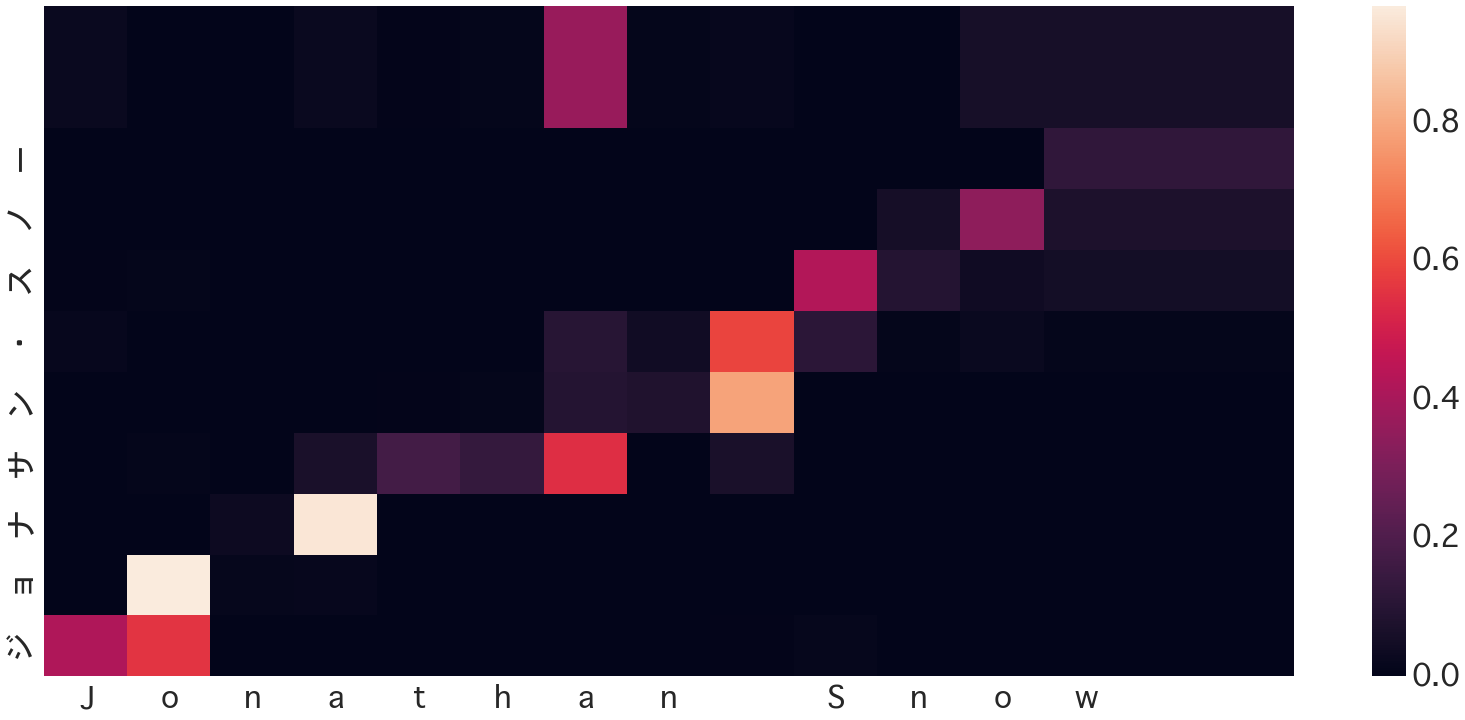

In [210]:
visualize('Jonathan Snow')

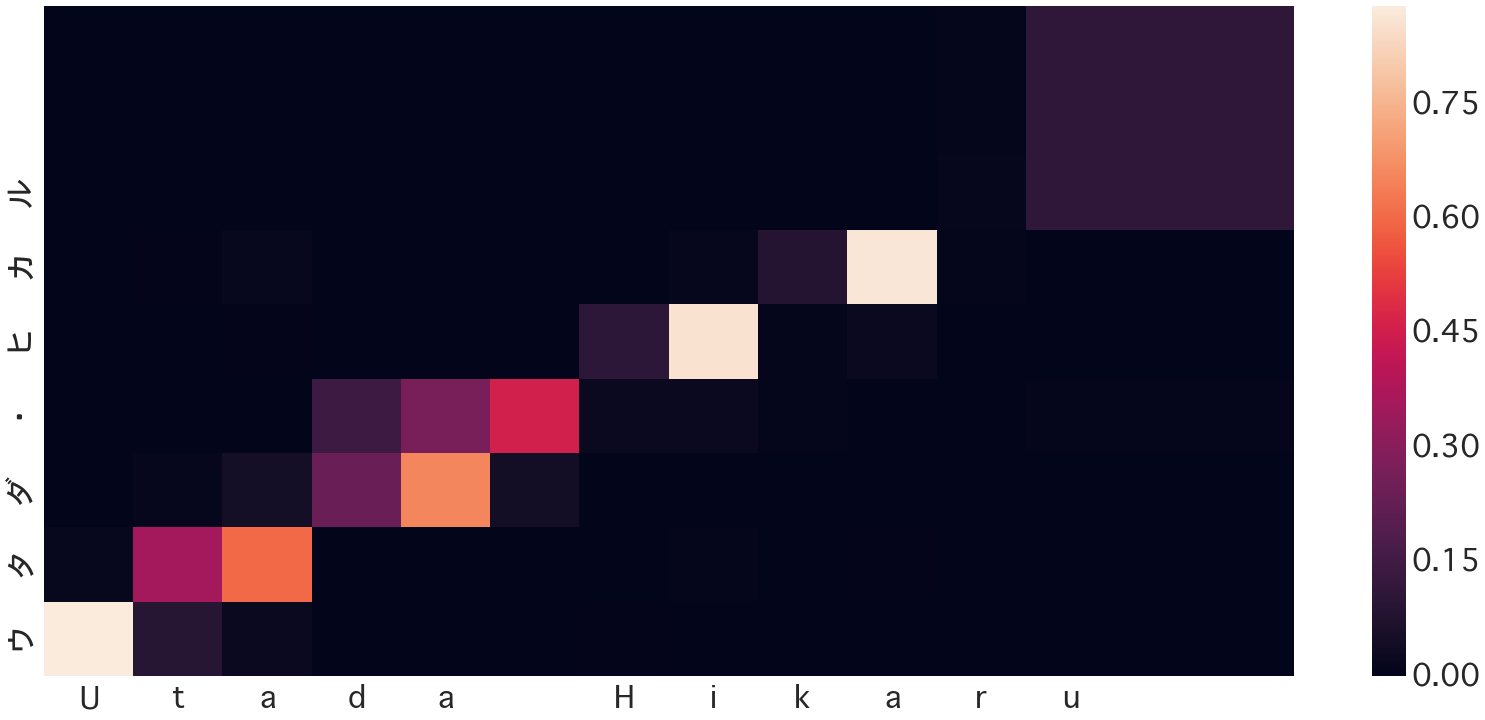

In [197]:
visualize('Utada Hikaru')

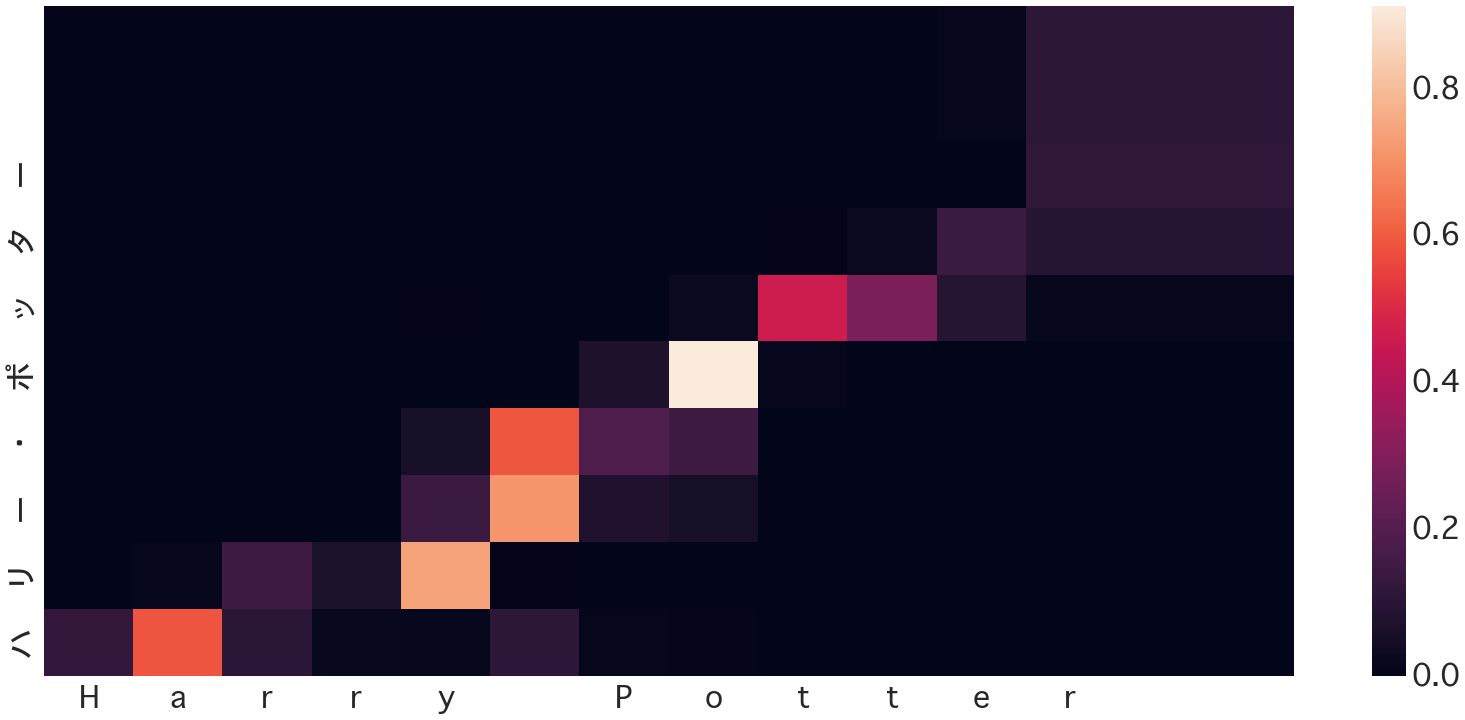

In [202]:
visualize('Harry Potter')